# SD204 TP:SVD-PCA

Autheur: Rui SONG

Ce notebook contient les réponses du TP noté dans le cours SD204.

## Imports et intialisation

In [1]:
import math                         # import a package
import numpy as np                  # import a package with specified name
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import train_test_split

/Users/songsophie/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/songsophie/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/songsophie/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.

## Exercice 1. (Retour sur l'algèbre linéaire)

### 1) Vérification de l'asutce du noyau

###### (a) n = 100 et p = 2000

In [2]:
n, p = 100, 2000
mu, sigma = 0, 2
lambd = 10^(-5)
X = np.random.normal(mu, sigma, (n,p))
y = np.random.uniform(-1, 1, n)

#Le résultat de la partie gauche:
start_time11 = time.time()
Xlambd1 = X.dot(X.T) + lambd*(np.identity(n)) 
z1 = np.linalg.solve(Xlambd1, y)
left = X.T.dot(z1.reshape(n,1)).reshape(p) 
end_time11 = time.time()

#Le résultat de la partie droite:
start_time12 = time.time()
Xlambd2 = X.T.dot(X) + lambd*(np.identity(p)) 
right = np.linalg.solve(Xlambd2, X.T.dot(y.reshape(n,1)).reshape(p))
end_time12 = time.time()

#Vérifier l'équalité:
print "With the function \'array_equal()\', the result is : " + str(np.array_equal(left, right))
print "With the function \'allclose()\', the result is : " + str(np.allclose(left, right))

With the function 'array_equal()', the result is : False
With the function 'allclose()', the result is : True


###### (b) n = 2000 et p = 100 

In [3]:
n, p = 2000, 100
X2 = np.random.normal(mu, sigma, (n,p))
y = np.random.uniform(-1, 1, n)

start_time21 = time.time()
Xlambd1 = X2.dot(X2.T) + lambd*(np.identity(n))
z1 = np.linalg.solve(Xlambd1, y)
left = X2.T.dot(z1.reshape(n,1)).reshape(p)
end_time21 = time.time()

start_time22 = time.time()
Xlambd2 = X2.T.dot(X2) + lambd*(np.identity(p))
right = np.linalg.solve(Xlambd2, X2.T.dot(y.reshape(n,1)).reshape(p))
end_time22 = time.time()

print "With the function \'array_equal()\', the result is : " + str(np.array_equal(left, right))
print "With the function \'allclose()\', the result is : " + str(np.allclose(left, right))

With the function 'array_equal()', the result is : False
With the function 'allclose()', the result is : True


Comme on peut voir dans les résultats précédents, si l'on utilise la fonction array_equal(), les deux parties de l'équation ne seront pas être équals, c'est parce que les deux matrices engendré par la fonction np.linalg.solve() ne sont pas totallement le même. Mais ils sont équals dans une tolérance.

### 2) Une étude numérique de la taille de n et p

On va utiliser le temps de l'execution dans les deux cas (n=100, p=2000 et n=2000, p=100):

In [4]:
print "Quand n = 100, p = 2000: "
print "Le temps pour calculer le gauche: %f" %(end_time11 - start_time11)
print "Le temps pour calculer le droit: %f" %(end_time12 - start_time12)

print "Quand n = 2000, p = 100: "
print "Le temps pour calculer le gauche: %f" %(end_time21 - start_time21)
print "Le temps pour calculer le droit: %f" %(end_time22 - start_time22)

Quand n = 100, p = 2000: 
Le temps pour calculer le gauche: 0.064640
Le temps pour calculer le droit: 0.251752
Quand n = 2000, p = 100: 
Le temps pour calculer le gauche: 0.185705
Le temps pour calculer le droit: 0.004012


Au vue des résultats au-dessus, on peut dire que si $n < p$, le calcul de la partie gauche de l'équation est plus intéressant; et que si $n > p$, le calcul de la partie droite de l'équation est plus intéressant. C'est parce que pour calculer la partie gauche, on résoud un système linénair de taille $n\times n$, et pour calculer la partie droite, on résoud un système linéaire de taille $p\times p$. On peut choisir selon la taille de $n$ et $p$ pour obtenir un plus petit système.

## Exercice 2 (Spectre de matrice aléatoire)

### 3) Construction des matrices

In [5]:
n2 = 1000
p2 = np.array([0, 200, 500, 1000, 2000])
pp = np.cumsum(p2)

Xtp = np.random.uniform(-math.sqrt(3), math.sqrt(3), (n2, np.sum(p2)))
X21 = [Xtp[:,pp[i]:pp[i+1]] for i in range(0,4)]
Xtp = np.random.laplace(0, math.sqrt(2)/2, (n2, np.sum(p2)))
X22 = [Xtp[:,pp[i]:pp[i+1]] for i in range(0,4)]

# singular value
valSin1 = []
for i in range(0,4):
    s, valSintp, v = np.linalg.svd(X21[i])
    valSin1.append(valSintp)

valSin2 = []
for i in range(0,4):
    s, valSintp, v = np.linalg.svd(X22[i])
    valSin2.append(valSintp)

### 4) Graphique des valeurs singulières

Afficher les valeurs singulière de matrices tirées de la loi uniforme:

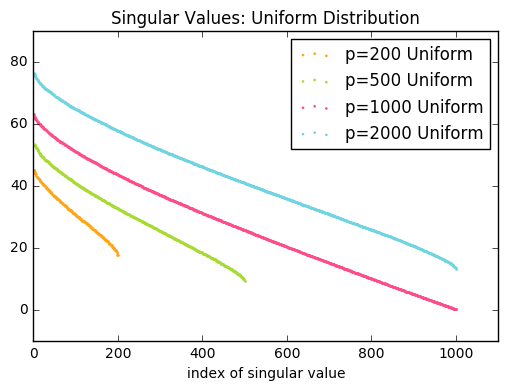

In [6]:
#point type and colors
area = np.pi * (0.5**2)
color1 = ['#FEA615', '#A7DB2F', '#FF4D8A', '#70D4E1', '#992099']
color2 = ['#21BCBC', '#FF2D7E', '#F9C80E', '#A2D729', '#F86624']

#Unifrom Distribution
plt.figure(1)
fig, axarr = plt.subplots()
axarr.set_title('Singular Values: Uniform Distribution')
axarr.scatter(np.linspace(1, 200, num=200), valSin1[0], label='p=200 Uniform', s=area, c=color1[0], edgecolors=color1[0])
axarr.scatter(np.linspace(1, 500, num=500), valSin1[1], label='p=500 Uniform', s=area, c=color1[1], edgecolors=color1[1])
axarr.scatter(np.linspace(1, 1000, num=1000), valSin1[2], label='p=1000 Uniform', s=area, c=color1[2], edgecolors=color1[2])
axarr.scatter(np.linspace(1, 1000, num=1000), valSin1[3], label='p=2000 Uniform', s=area, c=color1[3], edgecolors=color1[3])
axarr.set_xlabel("index of singular value")
axarr.set_xlim([0,1100])
plt.legend()
plt.show()

Afficher les valeurs singulière de matrices tirées de la loi Laplace:

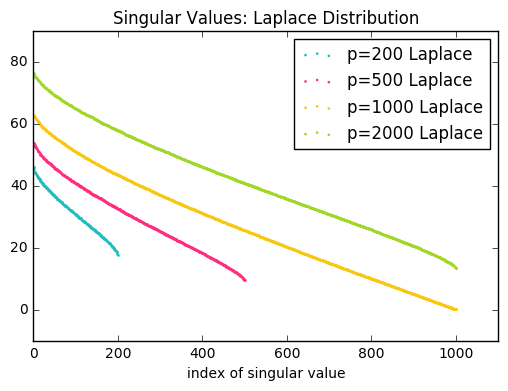

In [7]:
#Laplace Distribution
plt.figure(2)
fig, axarr = plt.subplots()
axarr.set_title('Singular Values: Laplace Distribution')
axarr.scatter(np.linspace(1, 200, num=200), valSin2[0], label='p=200 Laplace', s=area, c=color2[0], edgecolors=color2[0])
axarr.scatter(np.linspace(1, 500, num=500), valSin2[1], label='p=500 Laplace', s=area, c=color2[1], edgecolors=color2[1])
axarr.scatter(np.linspace(1, 1000, num=1000), valSin2[2], label='p=1000 Laplace', s=area, c=color2[2], edgecolors=color2[2])
axarr.scatter(np.linspace(1, 1000, num=1000), valSin2[3], label='p=2000 Laplace', s=area, c=color2[3], edgecolors=color2[3])
axarr.set_xlabel("index of singular value")
axarr.set_xlim([0,1100])
plt.legend()
plt.show()

### 5) Graphique de spectre

/Users/songsophie/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


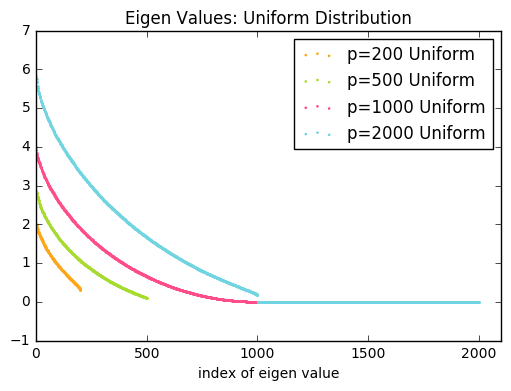

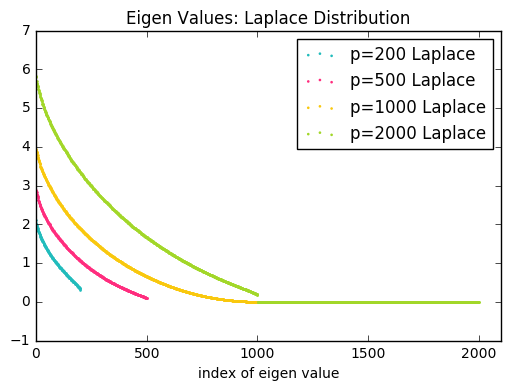

In [8]:
# Calculate the eigenvalues
#Uniform Distribution
XTXn1 = [X21[i].T.dot(X21[i])/n2 for i in range(0,4)] 
valPrp1 = []
for i in range(0,4):
    valPrptp, b = np.linalg.eig(XTXn1[i])
    valPrptp.sort()
    valPrptp = valPrptp[::-1]
    valPrp1.append(valPrptp)

#Laplace Distribution
XTXn2 = [X22[i].T.dot(X22[i])/n2 for i in range(0,4)]
valPrp2 = []
for i in range(0,4):
    valPrptp, b = np.linalg.eig(XTXn2[i])
    valPrptp.sort()
    valPrptp = valPrptp[::-1]
    valPrp2.append(valPrptp)

#plot the pictures
#Unifrom Distribution
plt.figure(3)
fig, axarr = plt.subplots()
axarr.set_title('Eigen Values: Uniform Distribution')
axarr.scatter(np.linspace(1, 200, num=200), valPrp1[0], label='p=200 Uniform', s=area, c=color1[0], edgecolors=color1[0])
axarr.scatter(np.linspace(1, 500, num=500), valPrp1[1], label='p=500 Uniform', s=area, c=color1[1], edgecolors=color1[1])
axarr.scatter(np.linspace(1, 1000, num=1000), valPrp1[2], label='p=1000 Uniform', s=area, c=color1[2], edgecolors=color1[2])
axarr.scatter(np.linspace(1, 2000, num=2000), valPrp1[3], label='p=2000 Uniform', s=area, c=color1[3], edgecolors=color1[3])
axarr.set_xlabel("index of eigen value")
axarr.set_xlim([0,2100])
plt.legend()

#Laplace Distribution
plt.figure(4)
fig, axarr = plt.subplots()
axarr.set_title('Eigen Values: Laplace Distribution')
axarr.scatter(np.linspace(1, 200, num=200), valPrp2[0], label='p=200 Laplace', s=area, c=color2[0], edgecolors=color2[0])
axarr.scatter(np.linspace(1, 500, num=500), valPrp2[1], label='p=500 Laplace', s=area, c=color2[1], edgecolors=color2[1])
axarr.scatter(np.linspace(1, 1000, num=1000), valPrp2[2], label='p=1000 Laplace', s=area, c=color2[2], edgecolors=color2[2])
axarr.scatter(np.linspace(1, 2000, num=2000), valPrp2[3], label='p=2000 Laplace', s=area, c=color2[3], edgecolors=color2[3])
axarr.set_xlabel("index of eigen value")
axarr.set_xlim([0,2100])
plt.legend()
plt.show()

Au vue du graphique au-dessus, il y a un gap au point de 1000, c'est parce que quand $p > n$, les valeurs propres seront complèxes.

## Exercice 3. (Méthode de la puissance itérée)

### 6) La fonction qui code l'algorithme 1

La fonction peut être écrit comme ci-dessous

In [9]:
def puissanceIt(Xf, nf, uf, vf):
    for i in range(0, nf):
        uf = Xf.dot(vf)#.reshape(p,1)) #np.dot(X, v)
        vf = Xf.T.dot(uf)#.reshape(n,1)) #np.dot(np.transpose(X), u)
        vf = vf/(np.linalg.norm(vf))
        uf = uf/(np.linalg.norm(uf))
    return uf, vf#.reshape(n), vf.reshape(p)

### 7) Convergence de l'algorithme

Pour illustrer visullenment la convergence, on va calculer la deuxième norme de la différence entre les vecteurs singuliers et les vecteurs $u$ et $v$, puis on va afficher les résultats dans un graphique.

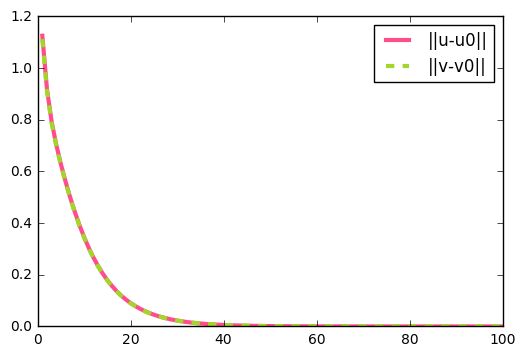

In [10]:
n = 100
p = 2000
u, valSin, v = np.linalg.svd(X)

u0 = u[:,0].reshape(n)
v0 = v[0,:].reshape(p)
u_ite = np.ones(n)/n
v_ite = np.ones(p)/p
n_ite = 100

norm_u = []
norm_v = []
# Apply the function and draw the graph
def norm_inverse(vect1, vect2):
    if(np.inner(vect1,vect2) < 0):
        return np.linalg.norm(-vect1-vect2)
    else:
        return np.linalg.norm(vect1-vect2)
    
for i in range(0, n_ite):
    u_ite, v_ite = puissanceIt(X, 10, u_ite, v_ite)
    u_ite = u_ite.reshape(n)
    v_ite = v_ite.reshape(p)
    normtp = norm_inverse(u_ite, u0)
    norm_u.append(normtp)
    normtp = norm_inverse(v_ite, v0)
    norm_v.append(normtp)

plt.figure(5)
plt.plot(np.linspace(1,len(norm_u),len(norm_u)),norm_u, label='||u-u0||', c=color1[2], linewidth=3)
plt.plot(np.linspace(1,len(norm_v),len(norm_v)),norm_v,'--', label='||v-v0||', c=color2[3], linewidth=3)
plt.legend()
plt.show()

Au vue du graphique au-dessus, on peut voir que les distances entre les vecteurs singulières et les vecteurs $u$ et $v$ tendent à diminuer vers zero. Alors on peut dire que les vecteurs $u$, $v$ obtenus approchent les vecteurs singuliers associés à la plus grande valeur singulière de $X$.

### 8) Diverses valeurs d'initialization

Pour demostrer que les vecteurs $u$ et $v$ vont converger vers les même solutions malgré leurs valeurs initiales, on va tier les deux vecteurs aléatoirement.

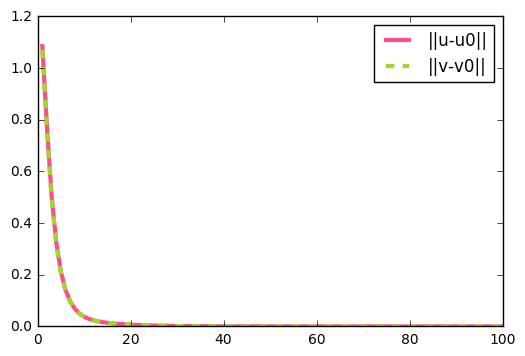

In [11]:
n = 100
p = 2000
np.random.seed(117)
u_ite = np.random.random(size=n)
v_ite = np.random.random(size=p)
n_ite = 100

norm_u = []
norm_v = []
# Apply the function and draw the graph
for i in range(0, n_ite):
    u_ite, v_ite = puissanceIt(X, 10, u_ite, v_ite)
    u_ite = u_ite.reshape(n)
    v_ite = v_ite.reshape(p)
    normtp = norm_inverse(u_ite, u0)
    norm_u.append(normtp)
    normtp = norm_inverse(v_ite, v0)
    norm_v.append(normtp)

plt.figure(5)
plt.plot(np.linspace(1,len(norm_u),len(norm_u)),norm_u, label='||u-u0||', c=color1[2], linewidth=3)
plt.plot(np.linspace(1,len(norm_v),len(norm_v)),norm_v,'--', label='||v-v0||', c=color2[3], linewidth=3)
plt.legend()
plt.show()

### 9) Trouver la seconde valeur singulière la plus grande

Pour obtenir les vecteurs associé à la seconde valeur singulière la plus grande de $X$, enlever les éléments défini par $u$ et $v$ obtenu par l'algorithme précédente, et puis appliquer l'algorithme au-dessus de nouveau en utilisant $X - s*u^{T}\cdot v$, d'où $s$ est la plus grande valeur singulière $s = u\cdot X\cdot v^{T}$, donc on a $X - u\cdot (u^{T}Xv)\cdot v^{T}$ pour remplacer $X$ dans l'algorithme 1

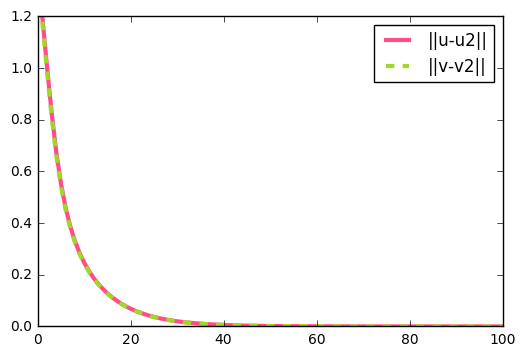

In [12]:
n = 100
p = 2000
u0 = u[:,0].reshape(n)
v0 = v[0,:].reshape(p)
u_ite = np.ones(n)/n
v_ite = np.ones(p)/p
u_ite, v_ite = puissanceIt(X, 5000, u_ite, v_ite)
#print u_ite.shape

u1 = u[:,1].reshape(n)
v1 = v[1,:].reshape(p) 
u1_ite = np.ones(n)/n
#print u1_ite.shape
v1_ite = np.ones(p)/p

norm_u1 = []
norm_v1 = []
uTXv = u_ite.dot(X).dot(v_ite.reshape(p,1))

X_suv = X - uTXv[0]*(u_ite.reshape(n,1)).dot(v_ite.reshape(1,p))

for i in range(0, n_ite):
    u1_ite, v1_ite = puissanceIt(X_suv, 5, u1_ite, v1_ite)
    u1_ite = u1_ite.reshape(n)
    v1_ite = v1_ite.reshape(p)
    normtp = norm_inverse(u1_ite, u1)
    norm_u1.append(normtp)
    normtp = norm_inverse(v1_ite, v1)
    norm_v1.append(normtp)

plt.figure(6)
plt.plot(np.linspace(1,len(norm_u1),len(norm_u1)),norm_u1, label='||u-u2||', c=color1[2], linewidth=3)
plt.plot(np.linspace(1,len(norm_v1),len(norm_v1)),norm_v1,'--', label='||v-v2||', c=color2[3], linewidth=3)
plt.legend()
plt.show()

Les vecteurs calculé par notre algorithms convergent aux vecteurs associeés à la seconde valeur singulière la plus grande de $X$. Cela vérifie que notre algorithms est correct.

## Exercice 4 (PCA)

### 10) Importer la base de données

In [13]:
na_values = ['?', '']
colIndex = ['England', 'Wales', 'Scotland','N Ireland']
rowIndex = ['Cheese', 'Carcass meat', 'Other meat','Fish','Fats and oils','Sugars','Fresh potatoes','Fresh Veg','Other Veg','Processed potatoes','Processed Veg','Fresh fruit','Cereals','Beverages','Soft drinks','Alcoholic drinks','Confectionery']
df = pd.read_csv('defra_consumption.csv',sep=';',index_col=0)#index_label=rowIndex, usecols=['Food','England', 'Wales', 'Scotland', 'N Ireland'])
df

,England,Wales,Scotland,N Ireland
Cheese,105,103,103,66
Carcass meat,245,227,242,267
Other meat,685,803,750,586
Fish,147,160,122,93
Fats and oils,193,235,184,209
Sugars,156,175,147,139
Fresh potatoes,720,874,566,1033
Fresh Veg,253,265,171,143
Other Veg,488,570,418,355
Processed potatoes,198,203,220,187


### 11) Centrer et réduire les données

In [14]:
X = preprocessing.scale(df)

### 12) Projection sur les Deux Premiers Axes Principaux

On va utiliser le module de decomposition de sklearn

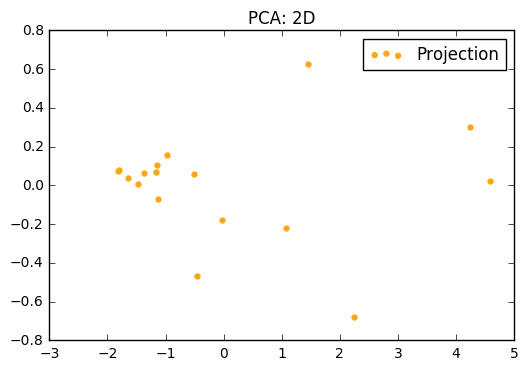

In [15]:
# Calculer les deux axes principaux en utilisant PCA
(n,p) = X.shape
start_time_PCA2D = time.time() #noter le temps
pca = PCA(n_components=2)  
newX = pca.fit_transform(X)
end_time_PCA2D = time.time() #noter le temps

# plot the picture
area = np.pi * (2**2)
plt.figure(7)
fig, axarr = plt.subplots()
axarr.set_title('PCA: 2D')
axarr.scatter(newX[:,0], -newX[:,1], s=area, label='Projection', c=color1[0], edgecolors=color1[0])
plt.legend()
plt.show()

### 13) Projection sur les Trois Premiers Axes Principaux

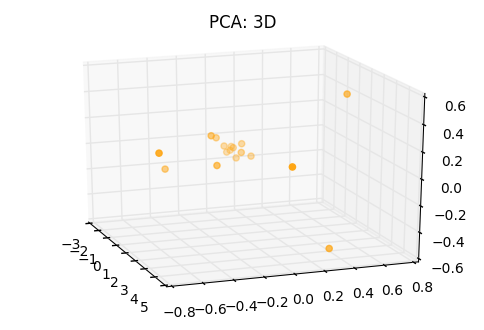

In [16]:
start_time_PCA3D = time.time()
pca2 = PCA(n_components=3)  
newX2 = pca2.fit_transform(X)
end_time_PCA3D = time.time()

# plot the picture
fig = plt.figure(8)
axarr3D = fig.add_subplot(111,projection='3d')
axarr3D.set_title('PCA: 3D')
axarr3D.scatter(newX2[:,0], -newX2[:,1], -newX2[:,2], label='Projection', c=color1[0], edgecolors=color1[0])
axarr3D.view_init(20, -20)
plt.show()

### 14) D'autres Manières

###### a) Vecteurs Propres

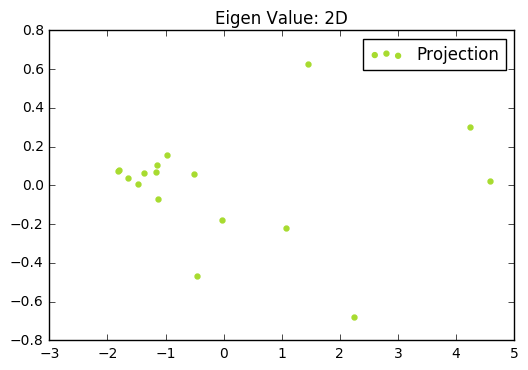

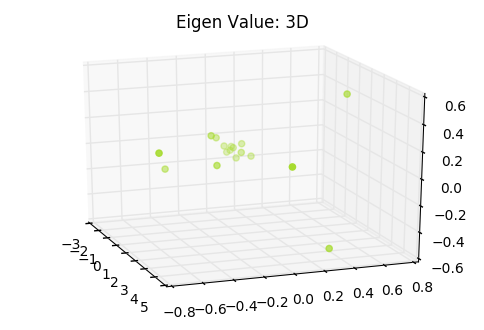

In [17]:
#2d
start_time_EIG2D = time.time()
Vlp, Mp = np.linalg.eigh(X.T.dot(X))
axe_eig = X.dot(Mp[:, -1:-3:-1])
end_time_EIG2D = time.time()

#3d
start_time_EIG3D = time.time()
Vlp_, Mp_ = np.linalg.eigh(X.T.dot(X))
axe_eig = X.dot(Mp_[:, -1:-4:-1])
end_time_EIG3D = time.time()

# plot the picture of 2d
plt.figure(9)
fig, axarr = plt.subplots()
axarr.set_title('Eigen Value: 2D')
axarr.scatter(-axe_eig[:,0], axe_eig[:,1], s=area, label='Projection', c=color1[1], edgecolors=color1[1])
plt.legend()
plt.show()

# plot the picture of 3d
fig = plt.figure(10)
axarr3D = fig.add_subplot(111,projection='3d')
axarr3D.set_title('Eigen Value: 3D')
axarr3D.scatter(-axe_eig[:,0],axe_eig[:,1],-axe_eig[:,2], label='Projection', c=color1[1], edgecolors=color1[1])
axarr3D.view_init(20, -20)
plt.show()

###### b) SVD

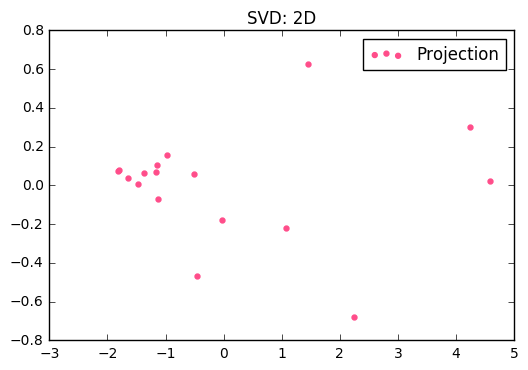

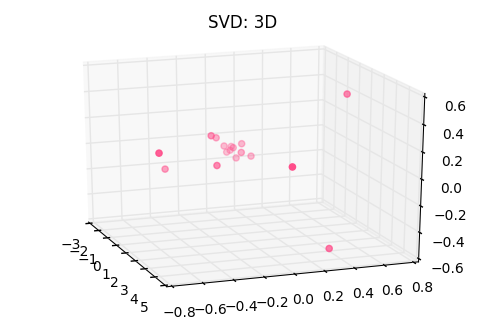

In [18]:
#2d
start_time_SVD2D = time.time()
u, s, v = np.linalg.svd(X)
axe_SVD_2D =X.dot( v[:2,:].T)
end_time_SVD2D = time.time()

#3d
start_time_SVD3D = time.time()
u_, s_, v_ = np.linalg.svd(X)
axe_SVD_3D =X.dot( v_[:3,:].T)
end_time_SVD3D = time.time()

# plot the picture of 2d
plt.figure(11)
fig, axarr = plt.subplots()
axarr.set_title('SVD: 2D')
axarr.scatter(axe_SVD_2D[:,0], axe_SVD_2D[:,1], s=area, label='Projection', c=color1[2], edgecolors=color1[2])
plt.legend()
plt.show()

# plot the picture of 3d
fig = plt.figure(12)
axarr3D = fig.add_subplot(111,projection='3d')
axarr3D.set_title('SVD: 3D')
axarr3D.scatter(axe_SVD_3D[:,0], axe_SVD_3D[:,1], axe_SVD_3D[:,2], label='Projection', c=color1[2], edgecolors=color1[2])
axarr3D.view_init(20, -20)
plt.show()

###### c) Le temps de calcul

On va comparer les différents temps d'execution par différentes manières en utilisant les temps noté dans chaque execution de code pour obtenir les projections.

In [19]:
print "PCA 2D: %f" %(end_time_PCA2D-start_time_PCA2D) 
print "PCA 3D: %f" %(end_time_PCA3D-start_time_PCA3D)
print "Eigen Value 2D: %f" %(end_time_EIG2D-start_time_EIG2D)
print "Eigen Value 3D: %f" %(end_time_EIG3D-start_time_EIG3D)
print "SVD 2D: %f" %(end_time_SVD2D-start_time_SVD2D)
print "SVD 3D: %f" %(end_time_SVD3D-start_time_SVD3D)

PCA 2D: 0.001266
PCA 3D: 0.000685
Eigen Value 2D: 0.000992
Eigen Value 3D: 0.000356
SVD 2D: 0.001356
SVD 3D: 0.000285


En utilisant PCA, le temps pour obtenir 2 axes principaux et 3 axes principaux est presque le même. Mais obtenir 3 axes est plus lentement qu'obtenir 2 axes en utilisant valeurs propres et SVD. Parmi les trois manières, SVD est plus rapide et PCA le deuxième plus rapide.

## Exercise 5 (Reconnaissance de visages par régression logistique)

### 15) Charger les données

In [20]:
from sklearn.datasets import fetch_lfw_people
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape ##The number of face images
X = lfw_people.data
n_features = X.shape[1] ##The number of avelled face images of original size 62 x 47 pixels
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0] ##The number of the names of the people corresponding to the images
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


### 16) Représention des variables explicatives

Les variables explicatives (features) ici sont les pixels pour chaque image d'une personne.

### 17) Réduction de nombre de variables explicatives

###### a)  l’ACP et le pourcentage d’inertie

On utilise l'attribut 'pca.explained_variance_ratio_' qui représente le pourcentage de variance expliqué par chacun des composants sélectionnés pour sélectionner le nombre d’attributs d'X avant régression logistique.

In [21]:
X = preprocessing.scale(X)

a_time_start = time.time()

percentage = np.linspace(0.5, 0.95, 50)
logistic = linear_model.LogisticRegression()
pca = PCA()  
PCA_X = pca.fit_transform(X)

ratio = np.cumsum(pca.explained_variance_ratio_)

score = []
a_time = []
n_components = []
for i in range(0, len(percentage)):
    nm_main_feature = len(ratio[ratio<percentage[i]])
    n_components.append(nm_main_feature)
    pctg_X = PCA_X[:,:nm_main_feature]
    logistic.fit(pctg_X, y)
    score.append(logistic.score(pctg_X, y))
    a_time.append(time.time()-a_time_start)

/Users/songsophie/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/songsophie/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


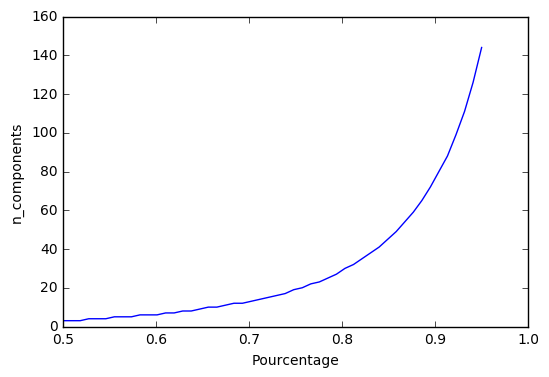

In [22]:
plt.figure(13)
fig, ax = plt.subplots()
ax.plot(percentage, n_components)
ax.set_xlabel("Pourcentage")
ax.set_ylabel("n_components")
plt.xlim(0.5, 1.0)
plt.show()

Au vue du graphique au-dessus, les axes calculé par l'ACP expliquent de moins en moins pourcentage d’inertie, donc pour explique autant pourcentage d'inertie, il faut de plus en plus de axes.

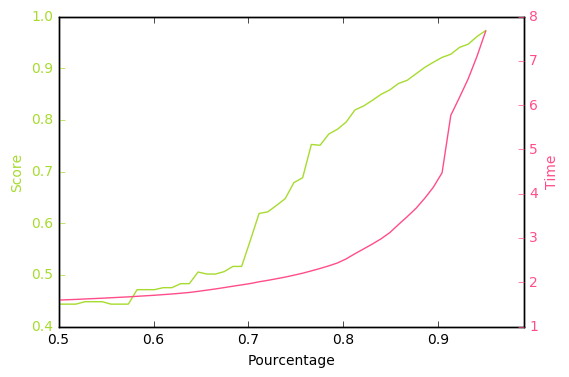

The attribute 'n_components' for the best estimator: 144.000000


In [23]:
plt.figure(13)
fig, ax1 = plt.subplots()
ax1.plot(percentage, score, c=color1[1])
ax1.set_ylabel("Score", color=color1[1])
ax1.set_xlabel("Pourcentage")
ax1.tick_params('y',colors=color1[1])
ax2 = ax1.twinx()
ax2.plot(percentage, a_time, c=color1[2], label="Time")
ax2.set_ylabel("Time", color=color1[2])
ax2.tick_params('y', colors=color1[2])
plt.xlim(0.5, 0.99)
plt.show()

print "The attribute \'n_components\' for the best estimator: %f" %(n_components[np.argmax(score)])

Si on utilise le pourcentage d’inertie pour séléctionner le nombre d'attribut, on tend à séléctionner autant d'attributs que possible, mais le temps de calcule va augmenter rapidement parce que le nombre d’attributs va augmenter rapidement. Cela sert à rien pour éviter de lancer la régression logistique sur un trop grand nombre de variables explicatives.

###### b) l'ACP et CV

<font color = "red">Note</font> : Puisque le module cross_validation sera retiré de la librairie scikit-learn après la version 0.20, on utilise un nouveau module model_selection qui est utilisable à partir de la version 0.18 de scikit-learn.

In [24]:
bt_1 = time.time()

n_components = [5,10,15,20,50,100,150]
logistic = linear_model.LogisticRegression()
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

estimator = GridSearchCV(estimator=pipe, param_grid=dict(pca__n_components=n_components), cv=3)
estimator.fit(X, y)
bt_2 = time.time()

print "The attribute \'n_components\' for the best estimator: %f" %(estimator.best_estimator_.named_steps['pca'].n_components)

The attribute 'n_components' for the best estimator: 50.000000


Si on utilise la validation croisée pour sélectionner le nombre de directions principales trouvées par l’ACP, on séléctionnera pas toujours le plus grand nombre de directions possible. Cela est utile pour éviter de lancer la régression logistique sur un trop grand nombre de variables explicatives. En utilisant CV et pipeline, on a testé 7 possibilité de nombre de directions [5,10,15,20,50,100,150]. Comme indiqué ci-dessus, le meilleure estimateur c'est quand le nombre de directions est 50, au lieu de 150.

## Exercice 6. (Analyse du jeu de données auto-mpg)

### 18) Importer avec Pandas la base de données

In [25]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original"
df = pd.read_csv(url, delim_whitespace = True, header=None, names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name'])
#print df

Le marqueur utilisé pour les données manquantes dans le fichier utilisé est 'NaN'. Et on utilise dropna() pour enlever les lignes possédant des valeurs manquantes dans la base de données.

In [26]:
df.dropna(inplace = True)
#print df

### 19) Calculer l’estimateur des moindres carrés et sa prédiction

In [27]:
data = df.values

part_X = data[:9, 1:7]
part_y = data[:9, 0]

regr = linear_model.LinearRegression()
regr.fit(part_X, part_y)

print u"L'estimateur des moindres carrés:"
print regr.coef_
predict_y = regr.predict(part_X)
print""
print u"Les prédictions de y:"
print predict_y
print""
print "Les vraies y:"
print part_y

L'estimateur des moindres carrés:
[ 0.          0.05408848 -0.0945306  -0.00424074 -0.19936701  0.        ]

Les prédictions de y:
[ 17.83593432  16.15135218  17.02803274  16.08414928  17.15247702
  14.85588522  14.27266143  14.2658702   13.35363761]

Les vraies y:
[18.0 15.0 18.0 16.0 17.0 15.0 14.0 14.0 14.0]


Les variables <b>cylinders</b> et <b>model year</b> sont tous pareils pour les 9 premières lignes, donc ils n'expliquent rien la prédiction de y. C'est pourquoi le première et le dernière paramètre de l'estimateur des moindres carrées sont zéro.

### 20) Moindres carrés sur l'intégralité des données

In [28]:
X = data[:, 1:7]
y = data[:, 0]

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

regr = linear_model.LinearRegression()
regr.fit(X, y)
predict_y = regr.predict(X)
print regr.coef_

[-0.56194996  0.80247616 -0.0150445  -5.76399971  0.23495704  2.77166415]


/Users/songsophie/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Au vue des paramères de l'estimateurs moindre carées, les deux variables qui expliquet le plus la consommation d'un véhicule, ce sont <b>weight</b> et <b>model year</b>.

### 21) Vérification numérique

In [29]:
n,p = X.shape

print "||r||^2 : %f" %(regr.residues_)
print "||r||^2/(n-p): %f" %(regr.residues_/(n-p))

yn = ((np.sum(y)/n)*(np.ones(n))).reshape(n)
left_ = y - yn
left = np.linalg.norm(left_)*np.linalg.norm(left_)
right_ = predict_y.reshape(n) - yn
right = regr.residues_ + np.linalg.norm(right_)*np.linalg.norm(right_)
print ""
print "Result of the left side: %f" %(left)
print "Result of the right side: %f" %(right)

||r||^2 : 4543.347025
||r||^2/(n-p): 11.770329

Result of the left side: 23818.993469
Result of the right side: 23818.993469


/Users/songsophie/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
/Users/songsophie/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
/Users/songsophie/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


On peut dire que la partie gauche est equale à la partie droite.

### 22) Prédicter un nouveau véhicule

In [30]:
newVehicule = [[6., 225., 100., 3233., 15.4, 76.]]
newVehicule = scaler.transform(newVehicule )
print "La consommation prédictée est: %f" %(regr.predict(newVehicule)[0])

La consommation prédictée est: 21.776220


### 23) Ajuster un modèle d'ordre deux

In [31]:
poly = PolynomialFeatures(degree = 2, interaction_only = False)
X_PolynomialFeatures = poly.fit_transform(X)

scaler_PolynomialFeatures = preprocessing.StandardScaler()
X_PolynomialFeatures = scaler_PolynomialFeatures.fit_transform(X_PolynomialFeatures)

regr_PolynomialFeatures = linear_model.LinearRegression()
regr_PolynomialFeatures.fit(X_PolynomialFeatures, y)
print "résidus - PolynomialFeatures: %f" %(regr_PolynomialFeatures.residues_)

résidus - PolynomialFeatures: 2688.731783


/Users/songsophie/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


Après la transformation PolynomialFeatures, les résidus est devenus 2688.731783, plus petits que 4543.347025 avant la transformation PolynomialFeatures. Alors on peut dire que la transformation PolynomialFeatures sert à mieux prédicter $y$.

### 24) Gérer la variable 'origin'

In [32]:
X = data[:, 1:7]
y = data[:, 0]
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

#get dummies
df_origin_dummies = pd.get_dummies(df, columns = ['origin'])
data_dummies = df_origin_dummies.values[:,8:]

# trainning data
X_dummies = np.c_[X, data_dummies]

# linear regression
regr2 = linear_model.LinearRegression(fit_intercept=False)
regr2.fit(X_dummies, y)
print "The coefficients for the three origins are: "
print regr2.coef_[6:]

The coefficients for the three origins are: 
[ 22.41468064  25.044683    25.26790886]


L'origin 'Japan' est la plus efficace en terme de consommation, parce que le coeffiance de cet attribut est le plus grand parmi les trois origins.

### 25) Gérer la variable 'brand'

In [33]:
# get brand names
brands = [data[i, 8].split(' ')[0] for i in range(0, n)]
# add a new column into the dataframe
df_brand = df_origin_dummies.assign(brand=brands)
df_brand = df_brand.drop(["car name"], axis=1)

# get dummies
df_brand_dummies = pd.get_dummies(df_brand, columns = ['brand'])
data_brand_dummies = df_brand_dummies.values
brand_dummies_colName = df_brand_dummies.columns.tolist()[10:]

# trainning data
X_brand_dummies = np.c_[X, data_brand_dummies[:,10:]]

# linear regression
regr_brand = linear_model.LinearRegression()
regr_brand.fit(X_brand_dummies, y)

# show results
brandMostEfficient = (brand_dummies_colName[np.argmax(regr_brand.coef_[9:])]).split('_')[1:]
print "Le marque le plus efficace en terme de consommation, c'est %s" %(brandMostEfficient[0])

Le marque le plus efficace en terme de consommation, c'est vokswagen


### 26) Trois valeurs de “levier” maximales

In [34]:
X = data[:, 1:7].astype(float)

U, S, V = np.linalg.svd(X, full_matrices=False)
H = U.dot(U.T)

print "H^T == H ? %s" %(str(np.allclose(H.T, H)))
print "H^2 == H ? %s" %(str(np.allclose(H.dot(H),H)))

H^T == H ? True
H^2 == H ? True


Avec $H^{T} = H$ et $H^{2} = H$, on peut dire que $H$ est une projection orthogonale.

In [35]:
leviers = np.diagonal(H)
leviers_order = -np.sort(-leviers)

# add a new column levier
df_levier = df.assign(levier=leviers)
df_levier = df_levier.drop(["origin"], axis=1)
df_levier = df_levier.drop(["car name"], axis=1)
#df_levier.sort_values(by="levier", ascending=False, inplace=True)
df_levier.sort(columns="levier", ascending=False, inplace=True)

# training data
data_levier = df_levier.values
X_levier = data_levier[:,1:]
y_levier = data_levier[:,0]

# preprocessiong
#scaler_levier = preprocessing.StandardScaler()
#X_levier_scale = scaler_levier.fit_transform(X_levier_scale)#.reshape(n,1)
#X_levier_scale = np.c_[X_levier_scale, leviers_order]
#print X_levier.shape

# linear regression
#regr_levier = linear_model.LinearRegression()
#regr_levier.fit(X_levier, y_levier)

# show the results
#print "predicted y : "
#print regr_levier.predict(X_levier)[:3]
#print "true y : "
#print y_levier[:3]
avg_X_levier = np.sum(X_levier, axis=0)/n
#print avg_X_levier
print "The average of each feature:"
print "cylinders: %f, displacement: %f, horsepower: %f, weight: %f, acceleration: %f, model year: %f" %(avg_X_levier[0],avg_X_levier[1],avg_X_levier[2],avg_X_levier[3],avg_X_levier[4],avg_X_levier[5]) 
print ""
print "The biggest leverage is : %f" %(X_levier[0,-1])
print "The features of the data with the biggest leverage are:"
print "cylinders: %f, displacement: %f, horsepower: %f, weight: %f, acceleration: %f, model year: %f" %(X_levier[0,0],X_levier[0,1],X_levier[0,2],X_levier[0,3],X_levier[0,4],X_levier[0,5])
print ""
print "The second biggest leverage is : %f" %(X_levier[1,-1])
print "The features of the data with the second biggest leverage are:"
print "cylinders: %f, displacement: %f, horsepower: %f, weight: %f, acceleration: %f, model year: %f" %(X_levier[1,0],X_levier[1,1],X_levier[1,2],X_levier[1,3],X_levier[1,4],X_levier[1,5])
print ""
print "The third biggest leverage is : %f" %(X_levier[2,-1])
print "The features of the data with the second biggest leverage are:"
print "cylinders: %f, displacement: %f, horsepower: %f, weight: %f, acceleration: %f, model year: %f" %(X_levier[2,0],X_levier[2,1],X_levier[2,2],X_levier[2,3],X_levier[2,4],X_levier[2,5])

The average of each feature:
cylinders: 5.471939, displacement: 194.411990, horsepower: 104.469388, weight: 2977.584184, acceleration: 15.541327, model year: 75.979592

The biggest leverage is : 0.186476
The features of the data with the biggest leverage are:
cylinders: 8.000000, displacement: 455.000000, horsepower: 225.000000, weight: 3086.000000, acceleration: 10.000000, model year: 70.000000

The second biggest leverage is : 0.080754
The features of the data with the second biggest leverage are:
cylinders: 8.000000, displacement: 304.000000, horsepower: 193.000000, weight: 4732.000000, acceleration: 18.500000, model year: 70.000000

The third biggest leverage is : 0.061674
The features of the data with the second biggest leverage are:
cylinders: 8.000000, displacement: 455.000000, horsepower: 225.000000, weight: 4425.000000, acceleration: 10.000000, model year: 70.000000


/Users/songsophie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Les variables explicatives (features) des voitures ayant les trois valeurs de “levier” maximales sont éloignés des moyennes de $X$. Les points avec des valeurs très grandes ou très petites X ont plus grand levier que les points ayant des valeurs X intermédiaires.